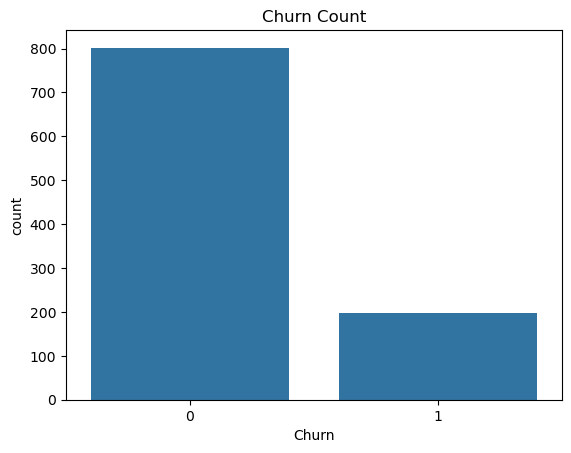

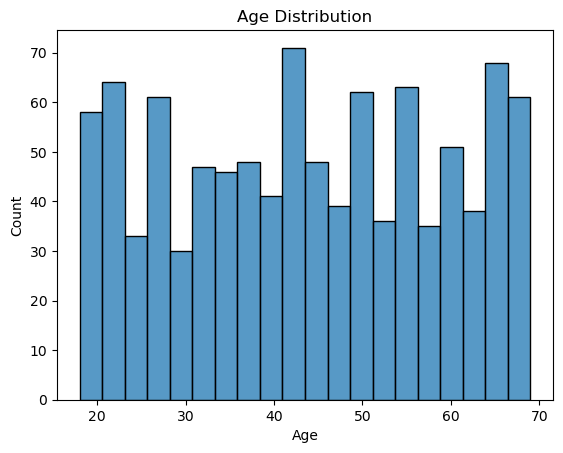

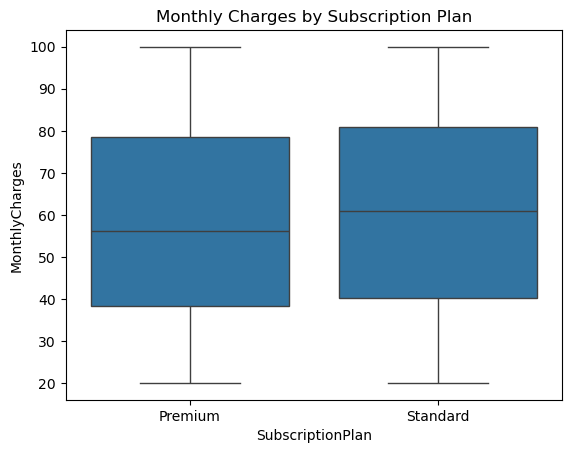

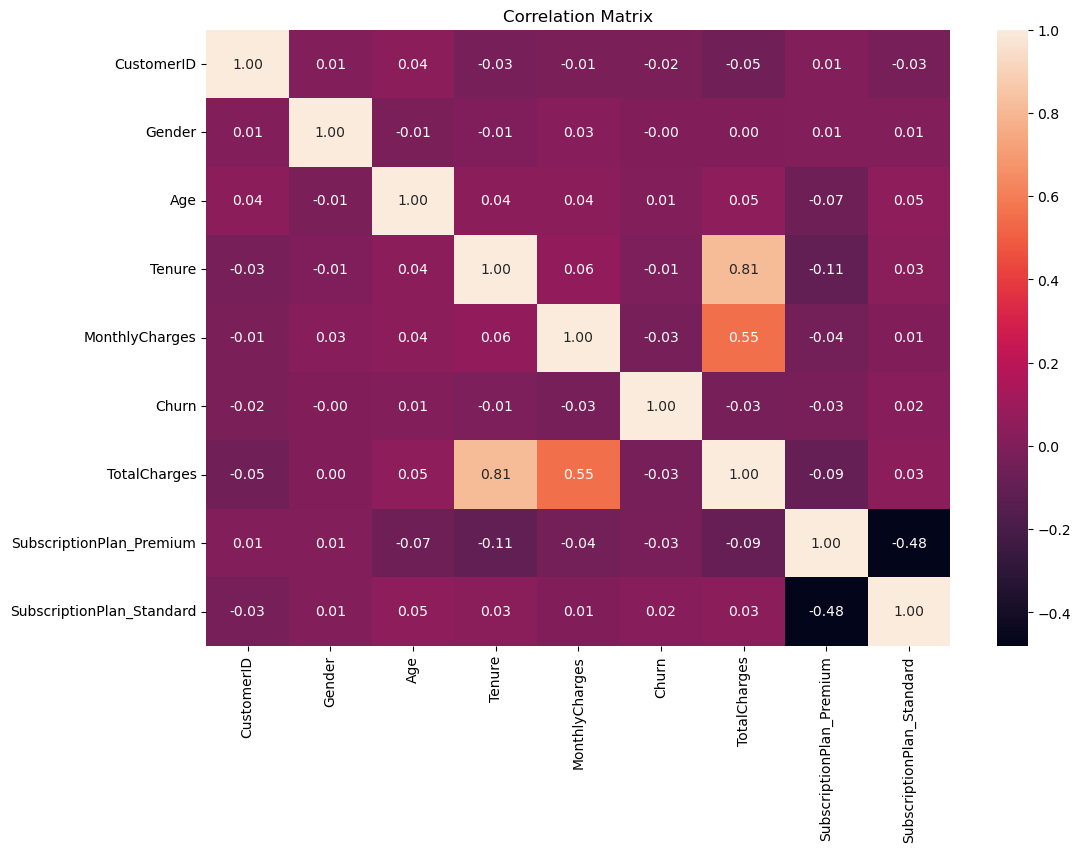

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       241
           1       0.22      0.03      0.06        59

    accuracy                           0.79       300
   macro avg       0.51      0.50      0.47       300
weighted avg       0.69      0.79      0.72       300

[[234   7]
 [ 57   2]]
ROC AUC Score: 0.47


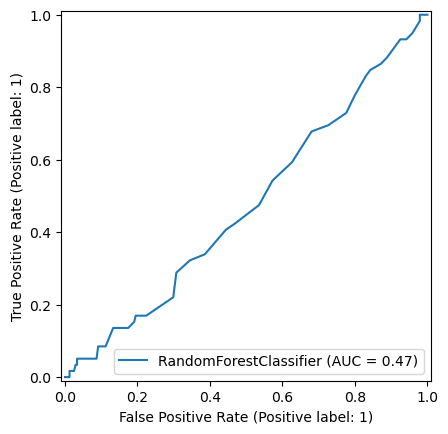

                           Importance
MonthlyCharges               0.263482
TotalCharges                 0.256261
Age                          0.203675
Tenure                       0.201136
Gender                       0.027964
SubscriptionPlan_Standard    0.024252
SubscriptionPlan_Premium     0.023231


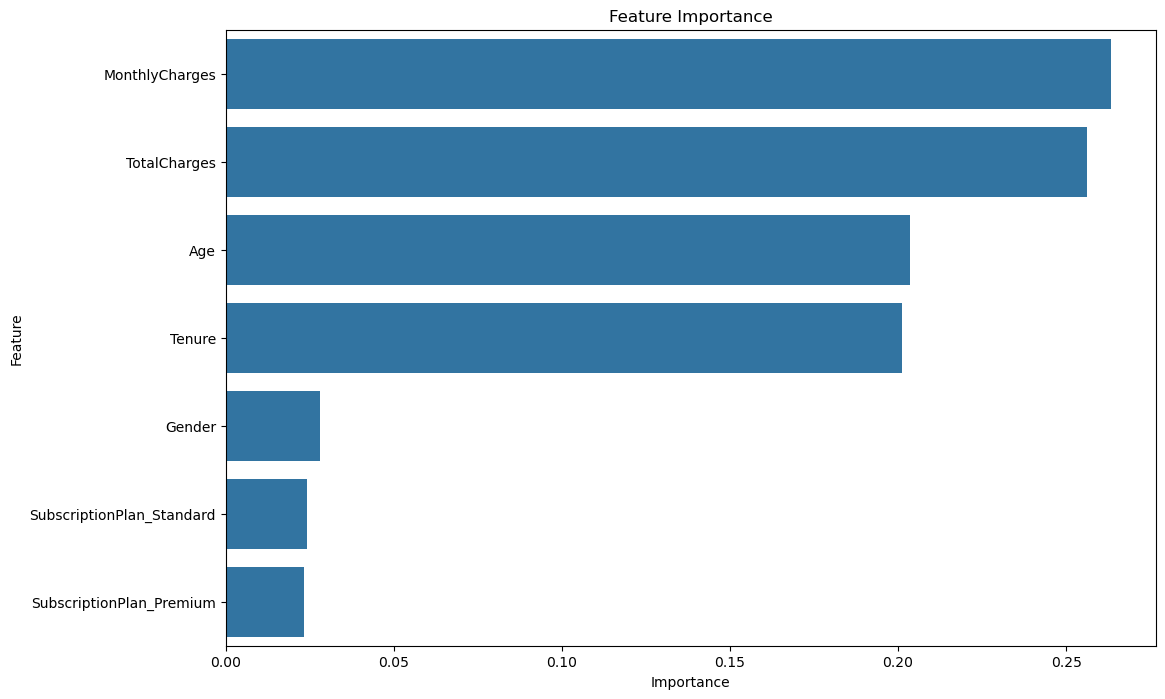

,CustomerID,Gender,Age,Tenure,MonthlyCharges,Churn,TotalCharges,SubscriptionPlan_Premium,SubscriptionPlan_Standard,SubscriptionPlan
0,1,1,34,11,91.22,0,1003.42,True,False,Premium
1,2,0,26,56,42.99,0,2407.44,False,True,Standard
2,3,1,50,67,49.42,0,3311.14,False,True,Standard
3,4,1,37,29,24.65,0,714.85,False,True,Standard
4,5,1,30,9,28.92,1,260.28,True,False,Premium


In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, roc_curve

# Step 2: Creating a Sample Dataset
np.random.seed(42)

data = pd.DataFrame({
    'CustomerID': np.arange(1, 1001),
    'Gender': np.random.choice(['Male', 'Female'], 1000),
    'Age': np.random.randint(18, 70, 1000),
    'Tenure': np.random.randint(1, 72, 1000),
    'SubscriptionPlan': np.random.choice(['Basic', 'Standard', 'Premium'], 1000),
    'MonthlyCharges': np.round(np.random.uniform(20, 100, 1000), 2),
    'Churn': np.random.choice([0, 1], 1000, p=[0.8, 0.2])  # 0 = No churn, 1 = Churn
})

data['TotalCharges'] = data['Tenure'] * data['MonthlyCharges']

# Step 3: Data Preprocessing
# Handling missing values (just a precaution; there shouldn't be any in this synthetic data)
data.dropna(inplace=True)

# Encoding categorical variables
# Label encoding for Gender
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])

# One-hot encoding for SubscriptionPlan
data = pd.get_dummies(data, columns=['SubscriptionPlan'], drop_first=True)

# Step 4: Exploratory Data Analysis (EDA)
# Churn count
sns.countplot(x='Churn', data=data)
plt.title('Churn Count')
plt.show()

# Age distribution
sns.histplot(data['Age'], bins=20)
plt.title('Age Distribution')
plt.show()

# Monthly charges by subscription plan
# Reconstruct SubscriptionPlan from one-hot encoding
data['SubscriptionPlan'] = data[['SubscriptionPlan_Standard', 'SubscriptionPlan_Premium']].idxmax(axis=1)
data['SubscriptionPlan'] = data['SubscriptionPlan'].str.replace('SubscriptionPlan_', '')
# Handle empty strings by assigning 'Basic'
data['SubscriptionPlan'] = data['SubscriptionPlan'].replace('', 'Basic')

sns.boxplot(x='SubscriptionPlan', y='MonthlyCharges', data=data)
plt.title('Monthly Charges by Subscription Plan')
plt.show()

# Correlation matrix (excluding 'SubscriptionPlan')
plt.figure(figsize=(12, 8))
corr_matrix = data.drop(columns=['SubscriptionPlan']).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Save the correlation matrix to a CSV file
corr_matrix.to_csv('correlation_matrix.csv')

# Load the wide-format correlation matrix
corr_matrix_wide = pd.read_csv('correlation_matrix.csv', index_col=0)

# Melt the correlation matrix to long format
corr_matrix_long = corr_matrix_wide.reset_index().melt(id_vars='index', var_name='Variable2', value_name='Correlation')
corr_matrix_long.rename(columns={'index': 'Variable1'}, inplace=True)

# Save the long-format correlation matrix to a new CSV
corr_matrix_long.to_csv('correlation_matrix_long.csv', index=False)

# Step 5: Train-Test Split
# Features and target variable
X = data.drop(columns=['CustomerID', 'Churn', 'SubscriptionPlan'])  # 'SubscriptionPlan' recreated for EDA
y = data['Churn']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 7: Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 8: Model Evaluation
y_pred = model.predict(X_test)

# Classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Additional evaluation metrics
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f'ROC AUC Score: {roc_auc:.2f}')

# ROC Curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

# Compute ROC curve data
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

# Create a DataFrame for ROC curve data
roc_data = pd.DataFrame({
    'FalsePositiveRate': fpr,
    'TruePositiveRate': tpr
})

# Save ROC curve data to a CSV file
roc_data.to_csv('roc_curve_data.csv', index=False)

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importances)

# Save the feature importances to a CSV file
feature_importances.to_csv('feature_importances.csv')

# Plot Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Export data for Tableau visualization
data.to_csv('churn_data.csv', index=False)
# Displaying the first few rows
data.head()

